# PythorchによるCycleGANの実装

In [1]:
# model.py
import torch
import torch.nn as nn
import torch.nn.functional as F

def conv(in_channels, out_channels, kernel_size=4, stride=2, padding=1, instance_norm=True, relu=True, relu_slope=None, init_zero_weights=False):

    layers = []
    conv_layer = nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, stride=stride, padding=padding, bias=True)
    if init_zero_weights:
        conv_layer.weight.data = torch.randn(out_channels, in_channels, kernel_size, kernel_size) * 0.001
    else:
        nn.init.normal_(conv_layer.weight.data, 0.0, 0.02)
    layers.append(conv_layer)

    if instance_norm:
        layers.append(nn.InstanceNorm2d(out_channels))

    if relu:
        if relu_slope:
            relu_layer = nn.LeakyReLU(relu_slope, True)
        else:
            relu_layer = nn.ReLU(inplace=True)
        layers.append(relu_layer)
    return layers

def deconv(in_channels, out_channels, kernel_size=4, stride=2, padding=1, output_padding=1, instance_norm=True, relu=True, relu_slope=None, init_zero_weights=False):

    layers = []
    deconv_layer = nn.ConvTranspose2d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, stride=stride, padding=padding, output_padding=output_padding, bias=True)
    if init_zero_weights:
        deconv_layer.weight.data = torch.randn(out_channels, in_channels, kernel_size, kernel_size) * 0.001
    else:
        nn.init.normal_(deconv_layer.weight.data, 0.0, 0.02)
    layers.append(deconv_layer)

    if instance_norm:
        layers.append(nn.InstanceNorm2d(out_channels))

    if relu:
        if relu_slope:
            relu_layer = nn.LeakyReLU(relu_slope, True)
        else:
            relu_layer = nn.ReLU(inplace=True)
        layers.append(relu_layer)
    return layers

class ResidualBlock(nn.Module):
    def __init__(self, input_features):
        super(ResidualBlock, self).__init__()

        conv_layers = [
                nn.ReflectionPad2d(1),
                *conv(input_features, input_features, kernel_size=3, stride=1, padding=0),
                nn.ReflectionPad2d(1),
                *conv(input_features, input_features, kernel_size=3, stride=1, padding=0, relu=False)
            ]
        self.model = nn.Sequential(*conv_layers)

    def forward(self, input_data):
        return input_data + self.model(input_data)

class CycleGenerator(nn.Module):

    def __init__(self, in_channels=3, out_channels=3, res_blocks=9):
        super(CycleGenerator, self).__init__()

        # First 7 x 7 convolutional layer
        layers = [
            nn.ReflectionPad2d(3),
            *conv(in_channels, 64, 7, stride=1, padding=0)
        ]

        # Two 3 x 3 convolutional layers
        input_features = 64
        output_features = input_features * 2
        for _ in range(2):
            layers += conv(input_features, output_features, 3)
            input_features, output_features = output_features, output_features * 2

        # Residual blocks
        for _ in range(res_blocks):
            layers += [ResidualBlock(input_features)]

        # Two 3 x 3 deconvolutional layers
        output_features = input_features // 2
        for _ in range(2):
            layers += deconv(input_features, output_features, 3)
            input_features, output_features = output_features, output_features // 2

        # Output layer
        layers += [
                nn.ReflectionPad2d(3),
                nn.Conv2d(input_features, out_channels, 7),
                nn.Tanh()
            ]
        self.model = nn.Sequential(*layers)

    def forward(self, real_image):
        return self.model(real_image)

class Discriminator(nn.Module):

    def __init__(self, in_channels=3, conv_dim=64):
        super(Discriminator, self).__init__()

        C64 = conv(in_channels, conv_dim, instance_norm=False, relu_slope=0.2)
        C128 = conv(conv_dim, conv_dim * 2, relu_slope=0.2)
        C256 = conv(conv_dim * 2, conv_dim * 4, relu_slope=0.2)
        C512 = conv(conv_dim * 4, conv_dim * 8, stride = 1, relu_slope=0.2)
        C1 = conv(conv_dim * 8, 1, stride=1, instance_norm=False, relu=False)

        self.model = nn.Sequential(
                *C64,
                *C128,
                *C256,
                *C512,
                *C1
            )

    def forward(self, image):
        return self.model(image)

In [2]:
#dataset.py
import os
import sys
import glob
import random

import torch
from torch.utils.data import Dataset
from PIL import Image
from torchvision import transforms


class CycleGANDataset(Dataset):

    def __init__(self, data_root="horse2zebra", transform=None, unaligned=True, mode='train'):

        # Check whether the dataset is downloaded

        self.transform = transform
        self.unaligned = unaligned

        self.files_A = sorted(glob.glob(data_root+'/'+f"{mode}A/*.*"))
        self.files_B = sorted(glob.glob(data_root+'/'+f"{mode}B/*.*"))
        

    def __getitem__(self, index):

        item_A = self.transform(Image.open(self.files_A[index % len(self.files_A)]).convert('RGB'))
        
        if self.unaligned:
            item_B = self.transform(Image.open(self.files_B[random.randint(0, len(self.files_B)-1)]).convert('RGB'))
        else:
            item_B = self.transform(Image.open(self.files_A[index % len(self.files_B)]).convert('RGB'))
        
        return {'A': item_A, 'B': item_B}

    def __len__(self):
        return max(len(self.files_A), len(self.files_B))

In [3]:
#lr_helpers.py
def get_lambda_rule():
    def lambda_rule(epoch):
        return 1.0 - max(0, epoch + start_epoch - decay_epoch) / float(epochs - decay_epoch)
    return lambda_rule

In [5]:
#train.py
import argparse
import os
import sys
import itertools
import math
import datetime
import time

import torchvision.transforms as transforms
from torchvision.utils import save_image
from torchvision import datasets

from torch.utils.data import DataLoader
from torch.autograd import Variable
import torch
import torch.nn as nn
from PIL import Image



def train_loop():

    if image_height == 128:
        res_blocks = 6
    elif image_height >= 256:
        res_blocks = 9

    # Create networks
    G_AB = CycleGenerator(a_channels, b_channels, res_blocks).to(device)
    G_BA = CycleGenerator(b_channels, a_channels, res_blocks).to(device)
    D_A = Discriminator(a_channels, d_conv_dim).to(device)
    D_B = Discriminator(b_channels, d_conv_dim).to(device)


    # Create losses
    criterion_gan = torch.nn.MSELoss()
    criterion_cycle = torch.nn.L1Loss()
    criterion_identity = torch.nn.L1Loss()

    if load:
        #TODO
        pass

    # Weights cycle loss and identity loss
    lambda_cycle = 10
    lambda_id = 0.5 * lambda_cycle

    # Create optimizers
    g_optimizer = torch.optim.Adam(itertools.chain(G_AB.parameters(), G_BA.parameters()),
                                    lr=lr, betas=(beta1, beta2))
    d_a_optimizer = torch.optim.Adam(D_A.parameters(), lr=lr, betas=(beta1, beta2))
    d_b_optimizer = torch.optim.Adam(D_B.parameters(), lr=lr, betas=(beta1, beta2))

    # Create learning rate update schedulers
    LambdaLR = get_lambda_rule()
    g_lr_scheduler = torch.optim.lr_scheduler.LambdaLR(g_optimizer, lr_lambda=LambdaLR)
    d_a_lr_scheduler = torch.optim.lr_scheduler.LambdaLR(d_a_optimizer, lr_lambda=LambdaLR)
    d_b_lr_scheduler = torch.optim.lr_scheduler.LambdaLR(d_b_optimizer, lr_lambda=LambdaLR)

    # Image transformations
    transform = transforms.Compose([transforms.Resize(int(image_height*1.12), Image.BICUBIC),
                                   transforms.RandomCrop((image_height, image_width)),
                                   transforms.RandomHorizontalFlip(),
                                   transforms.ToTensor(),
                                   transforms.Normalize([0.5],[0.5])])

    train_dataloader = DataLoader(CycleGANDataset(dataroot_dir, transform), batch_size=batch_size, shuffle=True, num_workers=0)
    test_dataloader = DataLoader(CycleGANDataset(dataroot_dir, transform, mode='test'), batch_size=5, shuffle=False, num_workers=0)


    end_epoch = epochs + start_epoch
    total_batch = len(train_dataloader) * epochs
    for epoch in range(start_epoch, end_epoch):
        for index, batch in enumerate(train_dataloader):
            # Create adversarial target
            real_A = Variable(batch['A'].to(device))
            real_B = Variable(batch['B'].to(device))
            fake_A, fake_B = G_BA(real_B), G_AB(real_A)

            # Train discriminator A
            d_a_optimizer.zero_grad()

            patch_real = D_A(real_A)
            loss_a_real = criterion_gan(patch_real, torch.tensor(1.0).expand_as(patch_real).to(device))
            patch_fake = D_A(fake_A)
            loss_a_fake = criterion_gan(patch_fake, torch.tensor(0.0).expand_as(patch_fake).to(device))
            loss_d_a = (loss_a_real + loss_a_fake) / 2
            loss_d_a.backward()
            d_a_optimizer.step()

            # Train discriminator B
            d_b_optimizer.zero_grad()
            patch_real = D_B(real_B)
            loss_b_real = criterion_gan(patch_real, torch.tensor(1.0).expand_as(patch_real).to(device))
            patch_fake = D_B(fake_B)
            loss_b_fake = criterion_gan(patch_fake, torch.tensor(0.0).expand_as(patch_fake).to(device))
            loss_d_b = (loss_b_real + loss_b_fake) / 2
            loss_d_b.backward()
            d_b_optimizer.step()

            # Train generator
            g_optimizer.zero_grad()
            fake_A, fake_B = G_BA(real_B), G_AB(real_A)
            reconstructed_A, reconstructed_B = G_BA(fake_B), G_AB(fake_A)
            
            # GAN loss　　#fake画像を本物と学習 (Adversarial Loss)
            patch_a = D_A(fake_A)
            loss_gan_ba = criterion_gan(patch_a, torch.tensor(1.0).expand_as(patch_a).to(device))
            patch_b = D_B(fake_B)
            loss_gan_ab = criterion_gan(patch_b, torch.tensor(1.0).expand_as(patch_b).to(device))
            loss_gan = (loss_gan_ab + loss_gan_ba) / 2

            # Cycle loss　　#fake画像をもとのドメインに変換し本物とのL1 Lossを計算
            loss_cycle_a = criterion_cycle(reconstructed_A, real_A)
            loss_cycle_b = criterion_cycle(reconstructed_B, real_B)
            loss_cycle = (loss_cycle_a + loss_cycle_b) / 2

            # Identity loss　　#変換後のドメイン画像はそのままであるべきなLoss
            loss_id_a = criterion_identity(G_BA(real_A), real_A)
            loss_id_b = criterion_identity(G_AB(real_B), real_B)
            loss_identity = (loss_id_a + loss_id_b) / 2

            # Total loss
            loss_g = loss_gan + lambda_cycle * loss_cycle + lambda_id * loss_identity
            loss_g.backward()
            g_optimizer.step()

            current_batch = epoch * len(train_dataloader) + index
            sys.stdout.write(f"\r[Epoch {epoch+1}/{epochs-start_epoch}] [Index {index}/{len(train_dataloader)}] [D_A loss: {loss_d_a.item():.4f}] [D_B loss: {loss_d_b.item():.4f}] [G loss: adv: {loss_gan.item():.4f}, cycle: {loss_cycle.item():.4f}, identity: {loss_identity.item():.4f}]")


        # Update learning reate
        g_lr_scheduler.step()
        d_a_lr_scheduler.step()
        d_b_lr_scheduler.step()
        if epoch % checkpoint_every == 0:
            torch.save(G_AB.state_dict(), f'{checkpoint_dir}/{dataset_name}/G_AB_{epoch}.pth')
            torch.save(G_BA.state_dict(), f'{checkpoint_dir}/{dataset_name}/G_BA_{epoch}.pth')
            torch.save(D_A.state_dict(), f'{checkpoint_dir}/{dataset_name}/D_A_{epoch}.pth')
            torch.save(D_B.state_dict(), f'{checkpoint_dir}/{dataset_name}/D_B_{epoch}.pth')

            

# モデル用ハイパーパラメータ
image_height=256
image_width=256
a_channels=3#A類画像のChannels数
b_channels=3#B類画像のChannels数.')
d_conv_dim=64

    　　　　　　　　# トレーニング用ハイパーパラメータ
dataset_name='facades'#'使用するデータセット.
epochs=10   　　　　#Epochの数
start_epoch=0
decay_epoch=5　　　#lr decayを実行し始めるEpoch数
batch_size=1　　　#一つのBatchに含まれる画像の数.
num_workers=0　　#'Dataloaderに使われるスレッド数.
lr=0.0002　　　　#学習率(defaultは0.0002)
beta1=0.5　　　　#'Adamオプチマイザーに使われるハイパーパラメータ.
beta2=0.999　　　#'Adamオプチマイザーに使われるハイパーパラメータ.
n_cpu=8　　　　　#'batchを生成するときに使用するスレッド数.
gpu_id=0, 　　　#'使用するGPUのID.

# サンプルやチェックポイントをとる頻度と場所
dataroot_dir='horse2zebra'
checkpoint_dir='checkpoints_cyclegan'
sample_dir ='samples_cyclegan'
load =None
log_step = 20
sample_every=100#'サンプルをとる頻度、batch単位.
checkpoint_every=1#'Check pointをとる頻度、epoch単位.



if __name__ == '__main__':



    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    os.makedirs(f"{sample_dir}/{dataset_name}", exist_ok=True)
    os.makedirs(f"{checkpoint_dir}/{dataset_name}", exist_ok=True)

    if load:
        sample_dir = '{}_pretrained'.format(sample_dir)
        sample_every = 20

#     print_()
    train_loop()

[Epoch 10/10] [Index 1333/1334] [D_A loss: 0.1634] [D_B loss: 0.2086] [G loss: adv: 0.4063, cycle: 0.1146, identity: 0.1281]

# 学習したモデルで実験

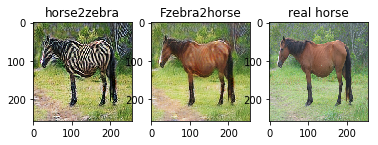

In [17]:
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.autograd import Variable
import torchvision.utils as vutils
from torchvision.utils import save_image
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
def load_img(filepath):
    img = Image.open(filepath).convert('RGB')
    img = img.resize((256, 256), Image.BICUBIC)
    return img

transform_list = [transforms.ToTensor(),
                  transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
transform = transforms.Compose(transform_list)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

PATH1 = "checkpoints_cyclegan/facades/G_BA_9.pth"
G_BA = CycleGenerator().to(device)
G_BA.load_state_dict(torch.load(PATH1))
    
PATH2 = "checkpoints_cyclegan/facades/G_AB_9.pth"
G_AB = CycleGenerator().to(device)
G_AB.load_state_dict(torch.load(PATH2))


img2 = load_img('horse2zebra/testA/n02381460_4530.jpg')
img = transform(img2)

input = img.unsqueeze(0).to(device)
real_A = Variable(input)
fake_B = G_AB(real_A)
reconstructed_A = G_BA(fake_B)

A2B = fake_B.detach().squeeze(0).cpu()
FB2A = reconstructed_A.detach().squeeze(0).cpu()
a2b= np.transpose(vutils.make_grid(A2B, padding=2, normalize=True),(1,2,0)).numpy()
fb2a= np.transpose(vutils.make_grid(FB2A, padding=2, normalize=True),(1,2,0)).numpy()

plt.subplot(1,3,1)
plt.title("horse2zebra")
plt.imshow(a2b)
plt.subplot(1,3,2)
plt.title("Fzebra2horse")
plt.imshow(fb2a)
plt.subplot(1,3,3)
plt.title("real horse")
plt.imshow(img2)

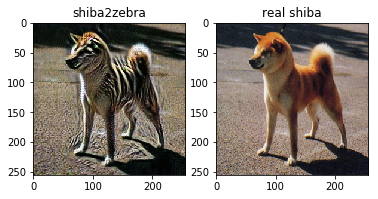

In [39]:
img2 = load_img('shiba/shiba2/b (47).jpg')
img = transform(img2)

input = img.unsqueeze(0).to(device)
real_A = Variable(input)
fake_B = G_AB(real_A)
reconstructed_A = G_BA(fake_B)

A2B = fake_B.detach().squeeze(0).cpu()
FB2A = reconstructed_A.detach().squeeze(0).cpu()
a2b= np.transpose(vutils.make_grid(A2B, padding=2, normalize=True),(1,2,0)).numpy()
fb2a= np.transpose(vutils.make_grid(FB2A, padding=2, normalize=True),(1,2,0)).numpy()

plt.subplot(1,2,1)
plt.title("shiba2zebra")
plt.imshow(a2b)
plt.subplot(1,2,2)
plt.title("real shiba")
plt.imshow(img2)

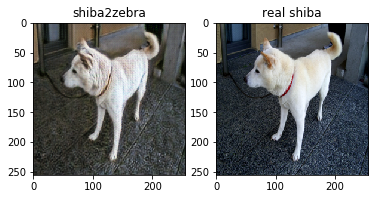

In [31]:
img2 = load_img('shiba/shiba2/w (27).jpg')
img = transform(img2)

input = img.unsqueeze(0).to(device)
real_A = Variable(input)
fake_B = G_AB(real_A)
reconstructed_A = G_BA(fake_B)

A2B = fake_B.detach().squeeze(0).cpu()
FB2A = reconstructed_A.detach().squeeze(0).cpu()
a2b= np.transpose(vutils.make_grid(A2B, padding=2, normalize=True),(1,2,0)).numpy()
fb2a= np.transpose(vutils.make_grid(FB2A, padding=2, normalize=True),(1,2,0)).numpy()

plt.subplot(1,2,1)
plt.title("shiba2zebra")
plt.imshow(a2b)
plt.subplot(1,2,2)
plt.title("real shiba")
plt.imshow(img2)

# 考察
PytorchでCycleGANを実装した。馬からシマウマへの変換はうまくいくものが多かった。馬のような形をした茶色が変換されているのではないかと思い、柴犬で試してみたところ赤柴ではうまく変換されているように見えたが白柴では変換されなかった。学習する馬とシマウマのデータセットではほとんどの馬が茶色であったことが原因であると考えられる。CycleGANの手法はPix2Pixと違い画像のペアを用意する必要がなく異なるドメイン間で学習することができる。DCGANと違いAdversal Lossに加えてIdentity Mapping LossとCycle Consistency Lossがある。Identity Mapping Lossでは、変換先ドメインの本物画像を入力したときはそのまま出力する制約を付けるlossで、Cycle Consistency Lossでは、fake画像を戻して元画像との損失を計算している。このことによってドメイン間の関係性の学習をするために、このlossを使用していると考えられる。